### Pleiades Download 
Pléiades 1A/1B are very-high resolution twin satellites offering 0.5m resolution products. The constellation is highly reactive and has been designed for daily revisit anywhere on Earth, with stereo and tri-stereo capacity. This block has a special feature: it is possible to order (and pay for) the data once and then run workflows using this data as often as needed.

In [3]:
import up42

In [4]:
# Authenticate and initialize project.
up42.authenticate(project_id="5678", 
                  project_api_key="uvwx")
project = up42.initialize_project()

2021-03-30 16:12:55,595 - Authentication with UP42 successful!
2021-03-30 16:12:56,577 - Initialized Project(name: Pleiades-Reflectance-Download-example, project_id: 78704e37-348d-4cf0-b1df-6761d218aa0a, description: , createdAt: 2021-03-22T09:41:59.789881Z)


In [5]:
# Construct the workflow.
workflow = project.create_workflow(name="Pleiades-download-example", use_existing=True)
input_tasks = ["oneatlas-pleiades-fullscene"]
workflow.add_workflow_tasks(input_tasks)

2021-03-30 16:12:56,582 - Getting existing workflows in project ...
2021-03-30 16:12:57,054 - Got 1 workflows for project 78704e37-348d-4cf0-b1df-6761d218aa0a.
100%|██████████| 1/1 [00:01<00:00,  1.50s/it]
2021-03-30 16:12:58,578 - Using existing workflow: Pleiades-download-example - 5c1fbe99-c528-41fd-9e99-81aa8f16f3ec
2021-03-30 16:13:02,322 - Added tasks to workflow: [{'name': 'oneatlas-pleiades-fullscene:1', 'parentName': None, 'blockId': 'defb134b-ca00-4e16-afa0-639c6dc0c5fe'}]


In [6]:
# Define the aoi.
aoi = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Polygon",
        "coordinates": [
            [
              [
                13.362627,
                52.489731
              ],
              [
                13.370466,
                52.489731
              ],
              [
                13.370466,
                52.493719
              ],
              [
                13.362627,
                52.493719
              ],
              [
                13.362627,
                52.489731
              ]
            ]
          ]
      }
    }
  ]
}


In [7]:
# We use catalogue search to have a quicklook for plotting. 
catalog = up42.initialize_catalog()
search_paramaters = catalog.construct_parameters(geometry=aoi, 
                                                 start_date="2019-01-01",
                                                 end_date="2020-12-31",
                                                 sensors=["pleiades"],
                                                 max_cloudcover=5,
                                                 sortby="acquisitionDate",
                                                 ascending=False,
                                                 limit=1)
search_paramaters["query"]["deliveryTime"] = {"in": ["MINUTES"]} 
search_results = catalog.search(search_paramaters)

2021-03-30 16:13:02,383 - Searching catalog with search_parameters: {'datetime': '2019-01-01T00:00:00Z/2020-12-31T23:59:59Z', 'intersects': {'type': 'Polygon', 'coordinates': (((13.362627, 52.489731), (13.370466, 52.489731), (13.370466, 52.493719), (13.362627, 52.493719), (13.362627, 52.489731)),)}, 'limit': 1, 'query': {'dataBlock': {'in': ['oneatlas-pleiades-fullscene', 'oneatlas-pleiades-display', 'oneatlas-pleiades-aoiclipped']}, 'cloudCoverage': {'lte': 5}, 'deliveryTime': {'in': ['MINUTES']}}, 'sortby': [{'field': 'properties.acquisitionDate', 'direction': 'desc'}]}
2021-03-30 16:13:03,004 - 1 results returned.


In [8]:
search_paramaters

{'datetime': '2019-01-01T00:00:00Z/2020-12-31T23:59:59Z',
 'intersects': {'type': 'Polygon',
  'coordinates': (((13.362627, 52.489731),
    (13.370466, 52.489731),
    (13.370466, 52.493719),
    (13.362627, 52.493719),
    (13.362627, 52.489731)),)},
 'limit': 1,
 'query': {'dataBlock': {'in': ['oneatlas-pleiades-fullscene',
    'oneatlas-pleiades-display',
    'oneatlas-pleiades-aoiclipped']},
  'cloudCoverage': {'lte': 5},
  'deliveryTime': {'in': ['MINUTES']}},
 'sortby': [{'field': 'properties.acquisitionDate', 'direction': 'desc'}]}

In [9]:
search_results

geometry  \
0  POLYGON ((13.21202 52.58004, 13.21264 52.45083...   

                                     id       acquisitionDate constellation  \
0  fa02819c-d04a-462a-9478-f1d8b9bd3e90  2020-05-06T10:19:18Z           PHR   

  collection providerName                                         blockNames  \
0        PHR     oneatlas  [oneatlas-pleiades-display, oneatlas-pleiades-...   

   cloudCoverage     up42:usageType  \
0           2.95  [DATA, ANALYTICS]   

                                  providerProperties  \
0  {'commercialReference': 'SO20033509', 'qualifi...   

                                             sceneId  resolution deliveryTime  \
0  DS_PHR1A_202005061019188_FR1_PX_E013N52_0513_0...         0.5      MINUTES   

  producer  
0   Airbus

2021-03-30 16:13:03,128 - Getting quicklooks from provider oneatlas for image_ids: ['fa02819c-d04a-462a-9478-f1d8b9bd3e90']
2021-03-30 16:13:03,129 - Download directory: /Users/wilhelmina.nekoto/repos/up42-py/examples/data-block-examples/project_78704e37-348d-4cf0-b1df-6761d218aa0a/catalog
100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


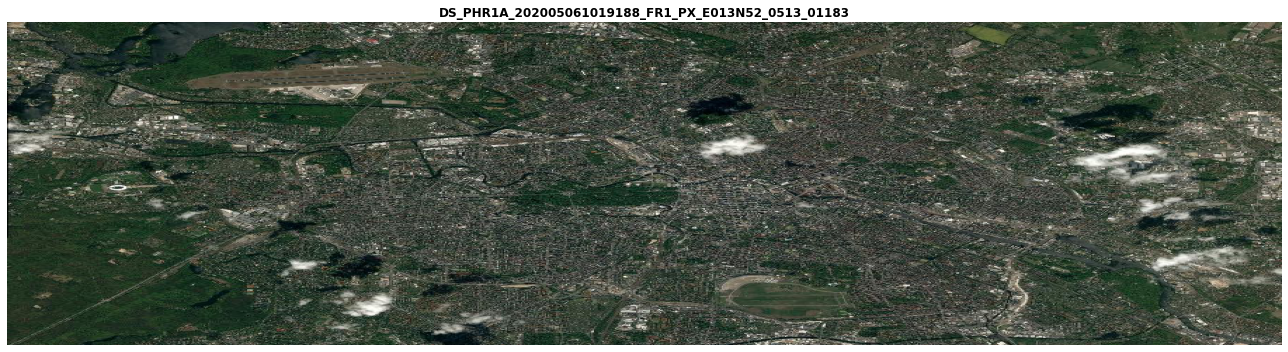

In [10]:
# Download & Visualise quicklooks.
catalog.download_quicklooks(image_ids=search_results.id.to_list(), sensor="pleiades")
# display(search_results.head())
catalog.plot_quicklooks(figsize=(18,5), titles=search_results.sceneId.to_list())

# Select least cloud scene for further workflow.
aoi["sceneId"] = search_results.sceneId.to_list()[0]

### Workflow construction and Job

In [11]:
input_parameters = workflow.construct_parameters(geometry=aoi, 
                                                 geometry_operation="bbox", 
                                                 scene_ids=[aoi["sceneId"]])

In [12]:
aoi

{'type': 'FeatureCollection',
 'features': [{'type': 'Feature',
   'properties': {},
   'geometry': {'type': 'Polygon',
    'coordinates': [[[13.362627, 52.489731],
      [13.370466, 52.489731],
      [13.370466, 52.493719],
      [13.362627, 52.493719],
      [13.362627, 52.489731]]]}}],
 'sceneId': 'DS_PHR1A_202005061019188_FR1_PX_E013N52_0513_01183'}

In [13]:
# Estimate price.
workflow.estimate_job(input_parameters)

2021-03-30 16:13:13,779 - Estimated: 241-253 Credits, Duration: 0-0 min.


{'oneatlas-pleiades-fullscene:1': {'blockConsumption': {'resources': {'unit': 'SQUARE_KM',
    'min': 0.24,
    'max': 0.252},
   'credit': {'min': 240, 'max': 252}},
  'machineConsumption': {'duration': {'min': 0, 'max': 0},
   'credit': {'min': 1, 'max': 1}}}}

In [14]:
# Run a test job to query data availability and check the configuration.
test_job = workflow.test_job(input_parameters, track_status=True)

2021-03-30 16:13:13,786 - +++++++++++++++++++++++++++++++++
2021-03-30 16:13:13,787 - Running this job as Test Query...
2021-03-30 16:13:13,788 - +++++++++++++++++++++++++++++++++
2021-03-30 16:13:13,789 - Selected input_parameters: {'oneatlas-pleiades-fullscene:1': {'limit': 1, 'max_cloud_cover': 100, 'ids': ['DS_PHR1A_202005061019188_FR1_PX_E013N52_0513_01183'], 'bbox': [13.362627, 52.489731, 13.370466, 52.493719]}, 'config': {'mode': 'DRY_RUN'}}
2021-03-30 16:13:15,924 - Created and running new job: 784decf5-83a0-4018-93a0-830fccf98b8a.
2021-03-30 16:13:16,510 - Tracking job status continuously, reporting every 30 seconds...
2021-03-30 16:13:50,345 - Job finished successfully! - 784decf5-83a0-4018-93a0-830fccf98b8a


In [15]:
# Run the actual live job.
job = workflow.run_job(input_parameters, track_status=True)

2021-03-30 16:13:55,356 - Selected input_parameters: {'oneatlas-pleiades-fullscene:1': {'limit': 1, 'max_cloud_cover': 100, 'ids': ['DS_PHR1A_202005061019188_FR1_PX_E013N52_0513_01183'], 'bbox': [13.362627, 52.489731, 13.370466, 52.493719]}}
2021-03-30 16:14:00,650 - Created and running new job: d398e145-2b33-47af-8d87-0889fdc625a8.
2021-03-30 16:14:01,152 - Tracking job status continuously, reporting every 30 seconds...
2021-03-30 16:14:35,889 - Job is RUNNING! - d398e145-2b33-47af-8d87-0889fdc625a8
2021-03-30 16:15:10,036 - Job is RUNNING! - d398e145-2b33-47af-8d87-0889fdc625a8
2021-03-30 16:15:43,214 - Job is RUNNING! - d398e145-2b33-47af-8d87-0889fdc625a8
2021-03-30 16:16:16,293 - Job is RUNNING! - d398e145-2b33-47af-8d87-0889fdc625a8
2021-03-30 16:16:51,357 - Job is RUNNING! - d398e145-2b33-47af-8d87-0889fdc625a8
2021-03-30 16:17:24,204 - Job is RUNNING! - d398e145-2b33-47af-8d87-0889fdc625a8
2021-03-30 16:17:57,688 - Job is RUNNING! - d398e145-2b33-47af-8d87-0889fdc625a8
2021-03-

In [ ]:
# Downlod Results.
job.download_results()

### Stack multiple RGB bands to plot a data visualisation for Pleiades reflectance download data.  
Here is a nice [tutorial](https://automating-gis-processes.github.io/site/notebooks/Raster/plotting-raster.html) to visualise this data. 

In [17]:
# Assign XML to path
xml_path = 'project_78704e37-348d-4cf0-b1df-6761d218aa0a/job_9c3f24e1-57b8-43d1-8b3d-43179013d2dd/DS_PHR1A_202005061019188_FR1_PX_E013N52_0513_01183/af5170a0-d240-4fd2-a79a-881216e8dc13/IMG_PHR1A_MS_002/DIM_PHR1A_MS_202005061019188_ORT_7d267ec6-2c9d-494e-c926-c1a51e870b54-002.XML'

In [18]:
import rasterio
import numpy as np
from matplotlib import pyplot

In [19]:
# Create a function to normalize the grid values.
def normalize(array):
    """Normalizes numpy arrays into scale 0.0 - 1.0"""
    array_min, array_max = array.min(), array.max()
    return ((array - array_min)/(array_max - array_min))

In [20]:
with rasterio.open(xml_path) as src: 
    red = normalize(src.read(1))
    green = normalize(src.read(2))
    blue = normalize(src.read(3))

In [22]:
# Concatenate the 3 dimensions into a variable (rgb).
rgb = np.dstack([red, green, blue])

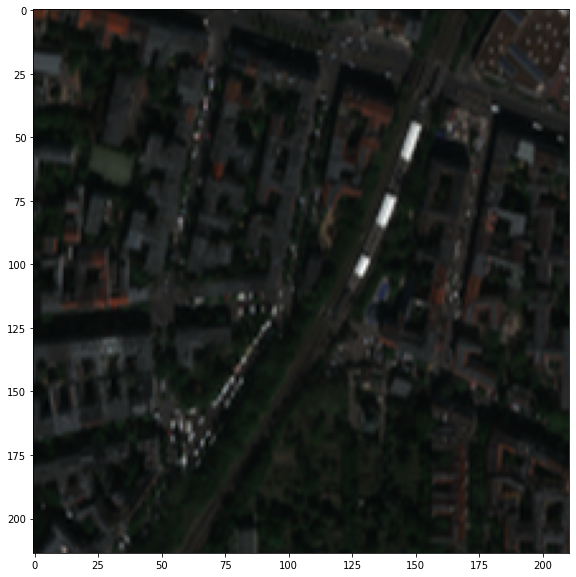

In [23]:
# Plot the results.
pyplot.figure(figsize=(10,10))
pyplot.imshow(rgb)

## Re-use the downloaded image
After running a job for the first time, the image downloaded from the upstream data provider gets a unique asset ID. 
To re-use this image in multiple workflows or during multiple job runs of the same workflow, follow the steps in this [tutorial](https://docs.up42.com/going-further/download-blocks-tutorial-spot-pleiades.html#how-to-re-use-the-downloaded-image)